In [3]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
import pandas as pd
import glob
import pickle
import numpy as np
from csslconstants import *
from cmcrameri import cm

from dirs import homedir, rawdatadir, datadir

datakeys = ['Date', 'Air Temp Max (C)', 'Air Temp Min (C)',
       '24-hour Total Precip (mm)', 'Season Total Precip (mm)',
       '% of Precip as Snow', '% of Precip as Rain', 'New Snow (cm)',
       'Season Total Snow (cm)', 'Snowpack depth (cm)',
       'Snow Water Equivalent (cm)', 'Remarks', 'dt']

In [4]:
## load data from the prep_cssl_data.py process
with open(datadir + 'cssldata.pickle', 'rb') as handle:
    cssl = pickle.load(handle)

In [5]:
## ## convert to a  nice csv file 
alldata = pd.DataFrame(columns=datakeys)
for i in datakeys[1:]:
    tmpdata = []
    alldates = []
    for k in sorted(cssl.keys()):
        data = cssl[k]
        try:
            y = data[i].values.astype(float)
        except:
            y = data[i].values
        for v in y: tmpdata.append(v)
        t = data['dt']
        for v in t: alldates.append(v)

    alldata[i] = tmpdata


alldata['Date'] = alldates
alldata.index = alldata.Date
alldata_even = alldata.resample('D').mean()

alldata_even[alldata_even['Air Temp Min (C)']>40] = np.nan
alldata_even.to_csv(datadir + 'cssldata.csv')
alldata_monthly = alldata_even.resample('M').mean()
alldata_monthly.to_csv(datadir + 'csslmonthly.csv')

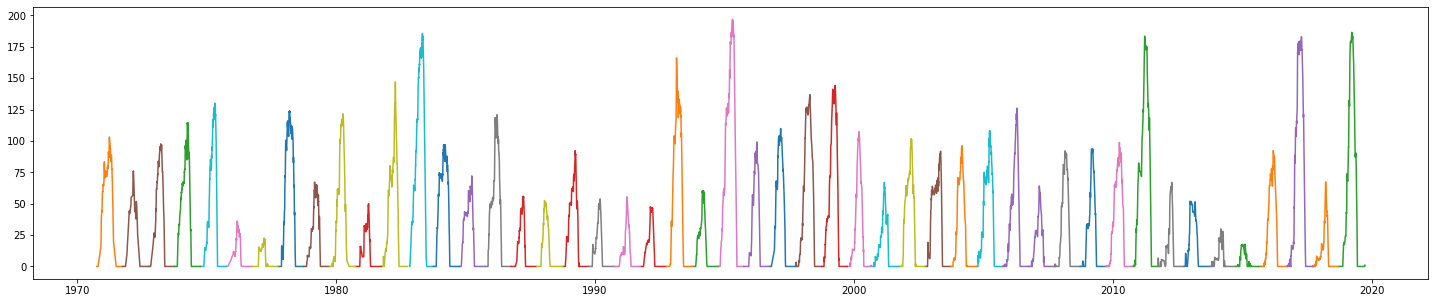

In [6]:
fig,ax = plt.subplots(figsize=(25,5))
for k in cssl.keys():
    data = cssl[k]
    y = pd.Series(data['Snow Water Equivalent (cm)'])
    y.index = index=data['dt']
    y2 = y.interpolate()
    ax.plot(y2)


/tmp/ipykernel_417/3689085631.py:26: RuntimeWarning: All-NaN axis encountered
  ax.plot(y.index[nans], [np.nanmax(y) for i in range(len(nans))],'o',markersize=5)
/tmp/ipykernel_417/3689085631.py:26: RuntimeWarning: All-NaN axis encountered
  ax.plot(y.index[nans], [np.nanmax(y) for i in range(len(nans))],'o',markersize=5)
/tmp/ipykernel_417/3689085631.py:26: RuntimeWarning: All-NaN axis encountered
  ax.plot(y.index[nans], [np.nanmax(y) for i in range(len(nans))],'o',markersize=5)
/tmp/ipykernel_417/3689085631.py:26: RuntimeWarning: All-NaN axis encountered
  ax.plot(y.index[nans], [np.nanmax(y) for i in range(len(nans))],'o',markersize=5)
/tmp/ipykernel_417/3689085631.py:26: RuntimeWarning: All-NaN axis encountered
  ax.plot(y.index[nans], [np.nanmax(y) for i in range(len(nans))],'o',markersize=5)
/tmp/ipykernel_417/3689085631.py:26: RuntimeWarning: All-NaN axis encountered
  ax.plot(y.index[nans], [np.nanmax(y) for i in range(len(nans))],'o',markersize=5)
/tmp/ipykernel_417/368908563

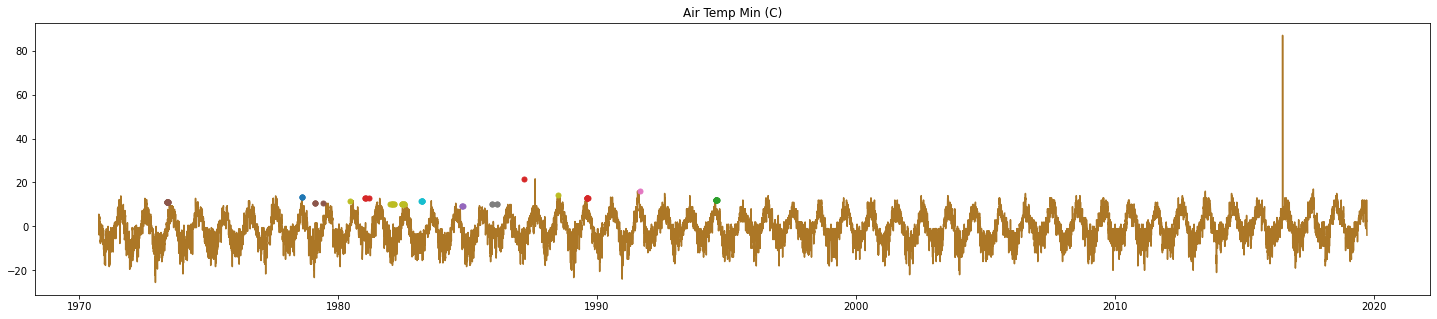

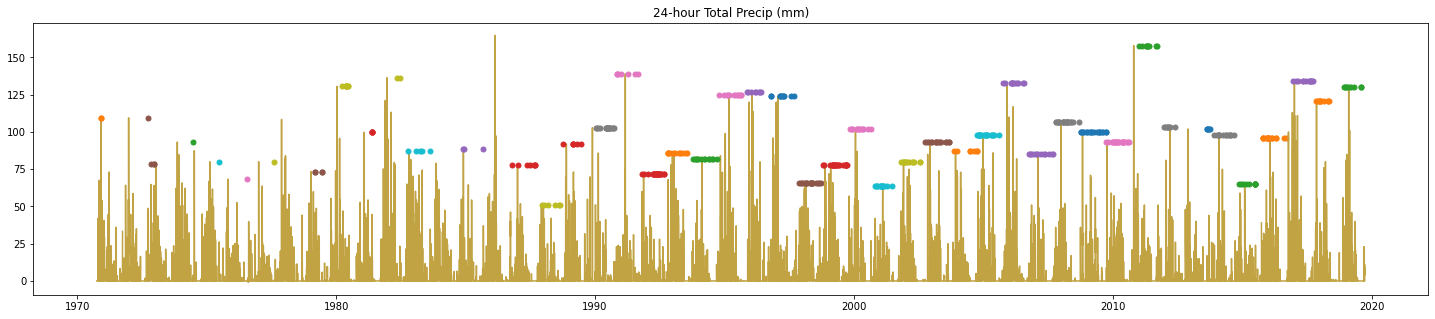

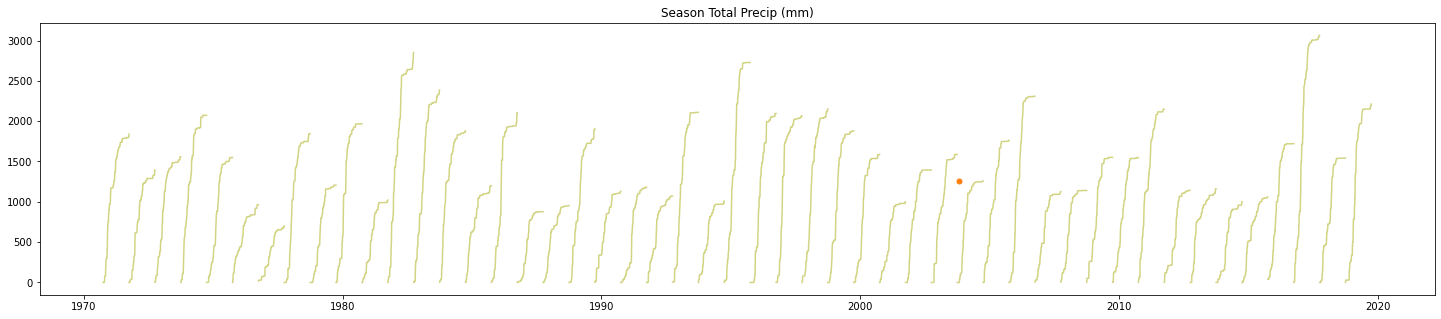

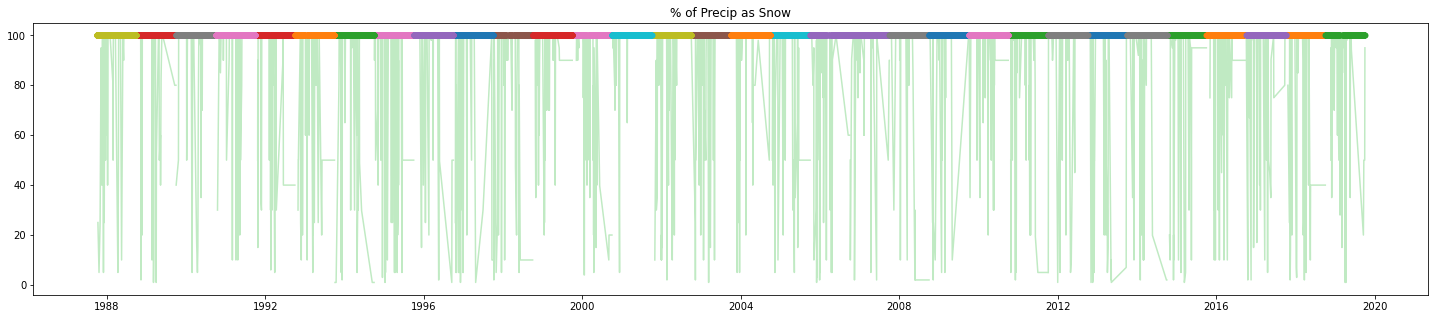

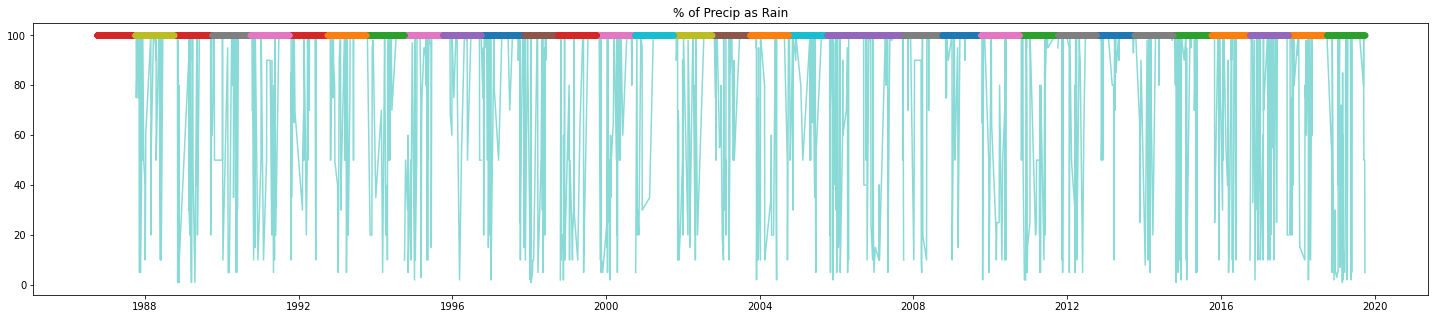

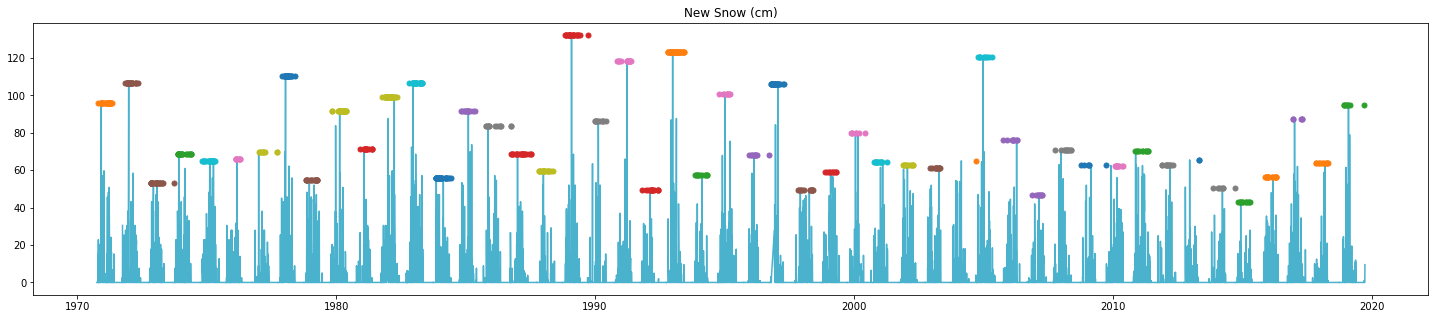

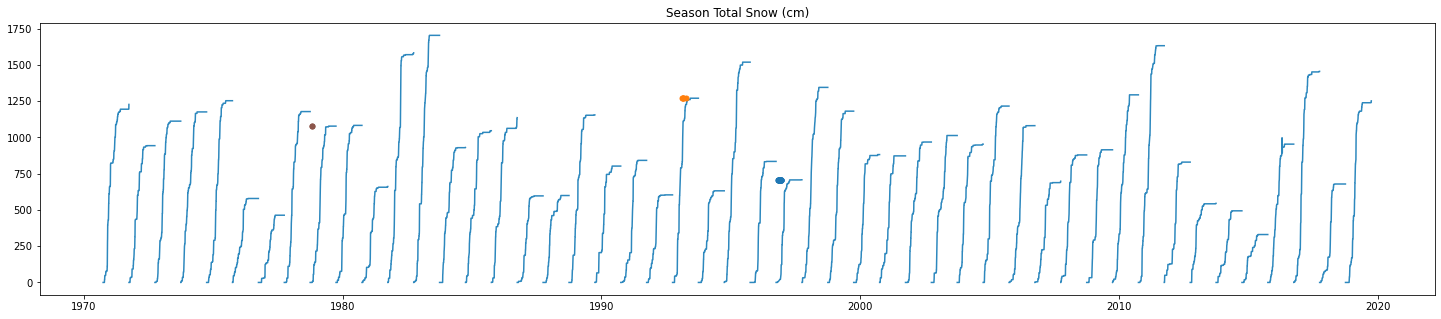

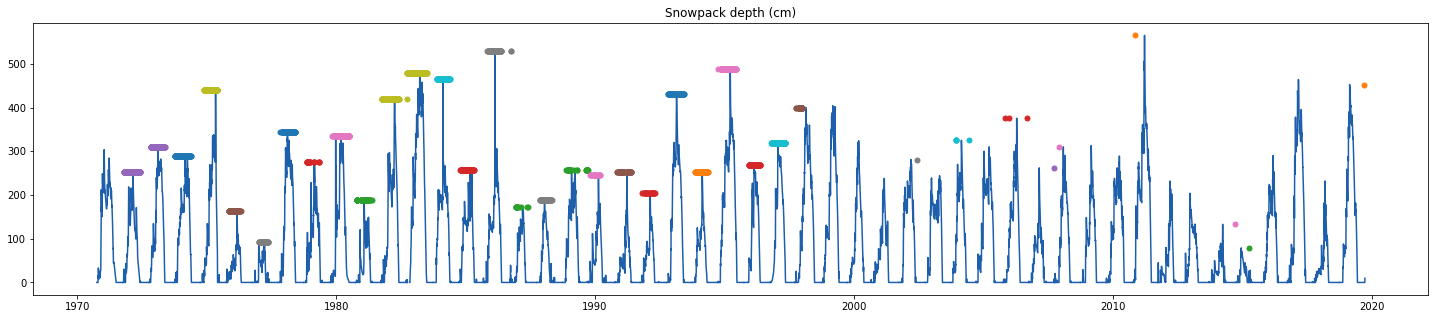

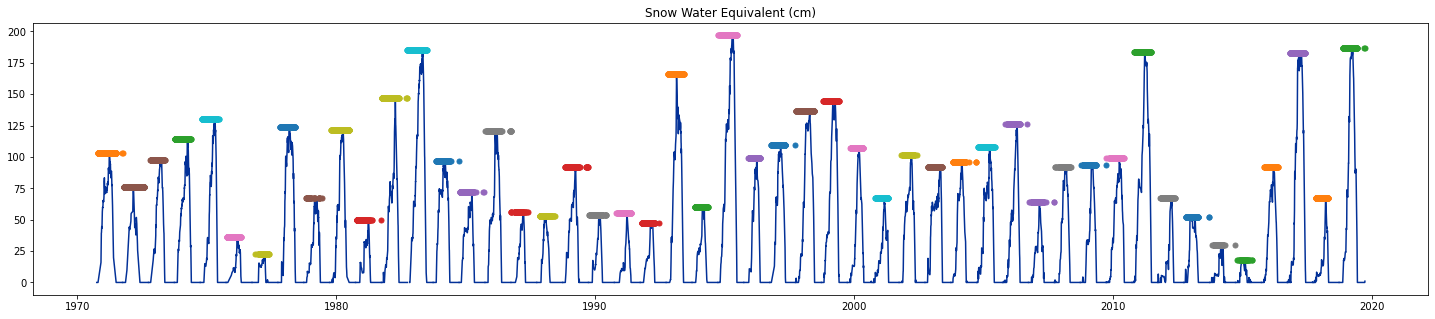

In [7]:
nannearvals = []
nanmos = []
nanyrs = []
cols = cm.roma(np.linspace(0,1,11))
for i in range(2,len(datakeys)-2):
    fig,ax = plt.subplots(figsize=(25,5))
    color = cols[i]
    for k in cssl.keys():
        data = cssl[k]
        try:
            y = pd.Series(data[datakeys[i]].astype('float'))
            y.index = index=data['dt']
            y2 = y.interpolate()
            ax.plot(y2,color=color)
            ax.set_title(datakeys[i])
        except:
            print(datakeys[i],k)
            continue
        try:
            nans = np.where(np.isnan(y))[0]
            if datakeys[i]== 'Snowpack depth (cm)':
                tmp1 = y.values[[i-1 for i in nans]]
                tmp2 = y.values[[i+1 for i in nans]]
                nannearvals.append(tmp1)
                nannearvals.append(tmp2)
            ax.plot(y.index[nans], [np.nanmax(y) for i in range(len(nans))],'o',markersize=5)
            motmp = y.index[nans].month
            nanmos.append(motmp)
            yeartmp = y.index[nans].year
            wytmp = []
            for val in motmp:
                if val <10:
                    wytmp.append(int(k)-1)
                else:
                    wytmp.append(int(k))
            nanyrs.append(wytmp)
        except:
            continue
plt.show()



In [8]:
nanmonth = []
for arr in nanmos:
    if len(arr)>0:
        for val in arr: nanmonth.append(val)
nanyear = []
for arr in nanyrs:
    if len(arr)>0:
        for val in arr: nanyear.append(val)
nanvalue = []
for arr in nannearvals:
    if len(arr)>0:
        for val in arr: nanvalue.append(val)

In [9]:
xs = np.arange(1,12)
hts = []
for i in range(1,12):
    tmp1 = pd.Series(nanmonth)
    tmp = tmp1[tmp1==i]
    hts.append(len(tmp))

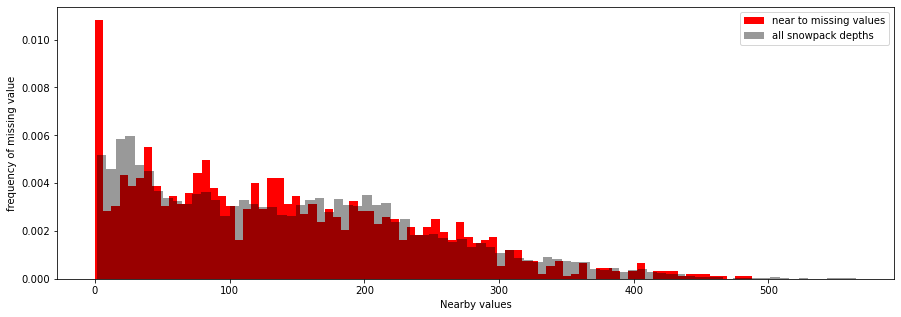

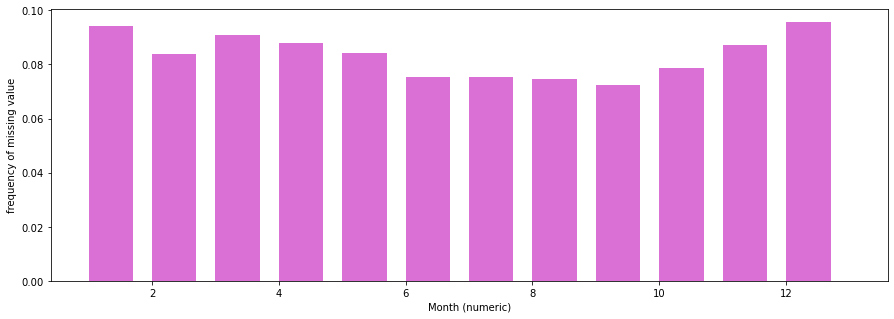

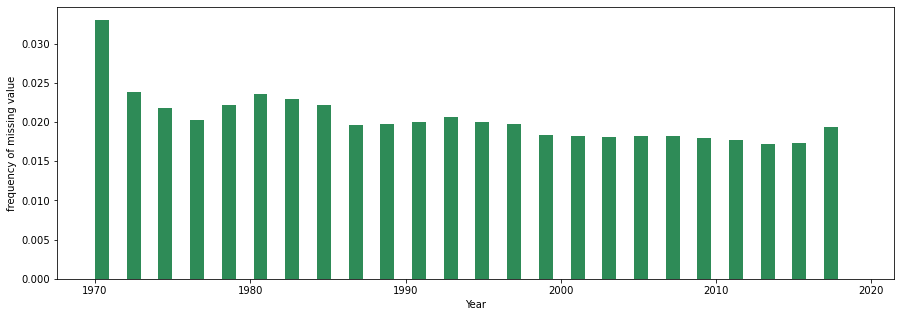

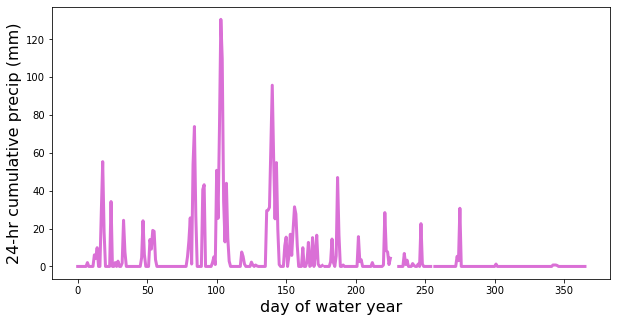

In [10]:
fig,ax = plt.subplots(figsize=(15,5))
nbins=80
ax.hist(np.array(nanvalue)[np.array(nanvalue)>-1],bins=nbins,density=True,color='red',label = 'near to missing values')
tmp = alldata['Snowpack depth (cm)']
ax.hist(tmp[tmp>1],bins=nbins,density=True,color='black',alpha=0.4,label='all snowpack depths')
ax.set_ylabel('frequency of missing value')
ax.set_xlabel('Nearby values')
ax.legend()
fig,ax = plt.subplots(figsize=(15,5))
ax.hist(nanmonth,bins=12,width=0.7,range=[1,13],density=True,color='orchid')
ax.set_ylabel('frequency of missing value')
ax.set_xlabel('Month (numeric)')
fig,ax = plt.subplots(figsize=(15,5))
ax.hist(nanyear,bins=24, width=0.9,density=True,color='seagreen')
ax.set_ylabel('frequency of missing value')
ax.set_xlabel('Year')
fig,ax=plt.subplots(figsize=(10,5))
#ax.plot(data['Air Temp Max (C)'].astype(float),color='darkred',label = 'Daily Max Temperature')
# ax.plot(data['Air Temp Min (C)'].astype(float),color = 'darkblue',label = 'Daily Min Temperature')
ax.plot(data['24-hour Total Precip (mm)'].astype(float),color='orchid',linewidth=3)
ax.set_ylabel('24-hr cumulative precip (mm)')
ax.set_xlabel('day of water year')
ax.title.set_size(20)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.show()


Text(0.5, 0, 'depth')

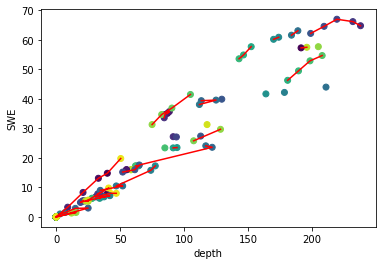

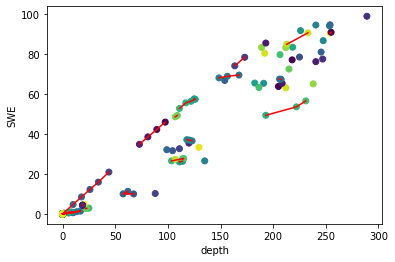

In [11]:
fig,ax=plt.subplots()
for k in ['2001']: # cssl.keys():
    data = cssl[k]
    x = pd.Series(data['Snowpack depth (cm)'].astype('float'))
    y = pd.Series(data['Snow Water Equivalent (cm)'].astype('float'))
    tmp = pd.Series(data['dt'])
    z =  [t.day for t in tmp]
    y.index = index=data['dt']
    ax.scatter(x,y,c= z, label=k)
    ax.plot(x,y,color='r')

# ax.legend()
ax.set_ylabel('SWE')
ax.set_xlabel('depth')

fig,ax=plt.subplots()
for k in ['2010']: # cssl.keys():
    data = cssl[k]
    x = pd.Series(data['Snowpack depth (cm)'].astype('float'))
    y = pd.Series(data['Snow Water Equivalent (cm)'].astype('float'))
    tmp = pd.Series(data['dt'])
    z =  [t.day for t in tmp]
    y.index = index=data['dt']
    ax.scatter(x,y,c= z, label=k)
    ax.plot(x,y,color='r')

# ax.legend()
ax.set_ylabel('SWE')
ax.set_xlabel('depth')

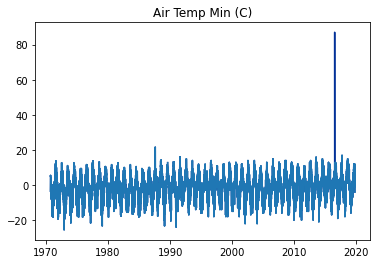

In [12]:
## what is the appropriate way to handle this as a state space model?
from scipy import signal
fig,ax=plt.subplots()
alltemp = []
alldates = []
i = 2
for k in cssl.keys():
        data = cssl[k]
        try:
            y = pd.Series(data[datakeys[i]].astype('float'))
            y.index = data['dt']
            y2 = y.interpolate()
            ax.plot(y,color=color)
            ax.set_title(datakeys[i])
            alltemp.append(list(y.values))
            alldates.append(list(y.index))
        except:
            print(datakeys[i],k)
            continue


temperature = [item for sublist in alltemp for item in sublist]
dates  =[item for sublist in alldates for item in sublist]
temp = pd.DataFrame(data = temperature,index = dates)
temperature = temp.sort_index()
temperature.columns = ['data']
## remove outliers
temperature.loc[temperature.data>30]=np.nan
plt.plot(temperature) ## should be identical minus the one large one


In [16]:
import scipy.io
import datetime
tele = scipy.io.loadmat(datadir + 'Teleconnections.mat')
data = tele['Teleconnections']
keys = ['Eur','IOD','NAO','Nino34']
teleconnections = pd.DataFrame(columns = keys)
for i in range(4):
    teleconnections[keys[i]] = data[:,i]

start = datetime.date(year = 1950,month=1,day=1)
# date_generated = [start + datetime.timedelta(month=x) for x in range(0, 852)]
min_month = "1950-01"
max_month = "2020-12"

months = pd.period_range(min_month, max_month, freq='M')
months
teleconnections.index =months
teleconnections.to_csv(datadir + 'teleconnections.csv')


In [17]:
## monthly anomalies for the data
alldata_monthly = alldata_even.resample('M').mean()
alldata_monthly.to_csv(datadir + 'csslmonthly.csv')
allkeys = list(alldata_monthly.keys())
newkeys = []
for k in allkeys:
    for i in range(1,13):
        newkey = k + '_a_' + str(i)
        newkeys.append(newkey)
#anomalykeys = [k+'_a' for k in allkeys]
#aak = allkeys + anomalykeys
#for k in anomalykeys:
#    alldata_monthly[k] = ''

month_anom = alldata_monthly.reindex(columns = alldata_monthly.columns.tolist() + newkeys)
#allkeys = alldata_monthly.keys()
#anomalykeys = [k+'_a' for k in allkeys]
for m in range(1,13):
    monthdata = alldata_monthly.loc[alldata_monthly.index.month==m]
    idxs = monthdata.index
    for k in allkeys[0:10]:
        tmp = monthdata[k]
        month_avg = np.nanmean(tmp)
        anomdata = [v-month_avg for v in tmp]
        adata_df = pd.DataFrame(data = anomdata, index = idxs)
        month_anom[k+'_a_'+str(m)] = adata_df


/tmp/ipykernel_417/1323028250.py:23: RuntimeWarning: Mean of empty slice
  month_avg = np.nanmean(tmp)


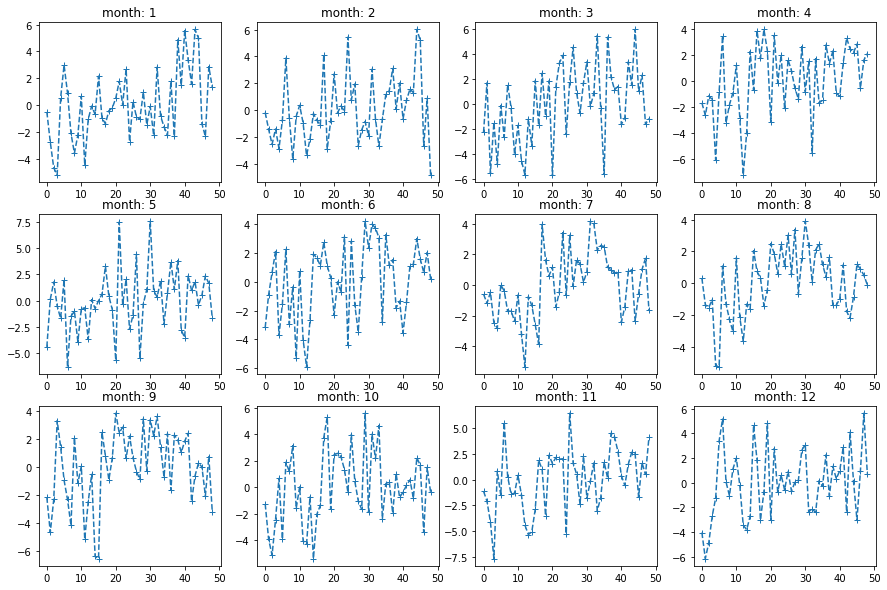

In [18]:
month_anom = pd.read_csv(datadir + 'monthlytemperatureanoms.csv')
fig,ax=plt.subplots(3,4,figsize=(15,10))
axs = ax.flatten()
anoms = pd.DataFrame()
for i in range(1,13):
    label = 'anom'+str(i)
    ts_tmp = month_anom['anom'+str(i)].values # .loc[month_anom.index.month==i]
    axs[i-1].plot(ts_tmp,'+--')
    axs[i-1].set_title('month: '+str(i))
    '''wy = []
    for val in ts_tmp.index:
        if val.month <10:
            wy.append(val.year-1)
        else:
            wy.append(val.year)
    ts_tmp.index = wy
    anoms[label] = ts_tmp'''
